# sorting

This notebook is used to sort through the listings from craigslist and identify those that mention parks in their description

## step one: data description
### listings
1. Load the listing data from the scraping notebook 
2. remove extra spaces and symbols and set the text to all lowercase. 
3. delete duplicate listings 

In [204]:
listingsDf_trim = pd.read_pickle('combined_df.pkl')

In [205]:
import re

def remove_and_clean(text):
    text = re.sub(("\n"), " ", text)
    text = text.lower()
    return text

listingsDf_trim['description'] = listingsDf_trim['description'].apply(remove_and_clean)

In [206]:
listingsDf_trim.drop_duplicates(subset='description', inplace=True)

**start sorting**

we want to sort the listings to see insantances when parks are mentioned. to do so we loaded a parks file from the county data hub with the names and loactions of all the parks in the county.  

In [207]:
import geopandas as gpd

parks = gpd.read_file('county_parks.geojson')
parks.sample(2)

,OBJECTID,UNIT_ID,LMS_ID,PARK_NAME,PARK_LBL,ACCESS_TYP,RPT_ACRES,GIS_ACRES,AGNCY_NAME,AGNCY_LEV,...,CENTER_LON,ADDRESS,CITY,ZIP,HOURS,PHONES,IS_COUNTY,Shape__Area,Shape__Length,geometry
1418,1419,12586.0,NaN,SMMNRA - Backbone Trail,SMMNRA - Backbone Trail,Open Access,32.451,32.450390,United States National Park Service,Federal,...,-118.805100,Encinal Canyon Rd,Malibu,90265,NaN,NaN,No,1.413533e+06,5409.274251,"POLYGON ((-118.80436 34.07460, -118.80453 34.0..."
0,1,30.0,23603.0,El Barrio Park,El Barrio Park,Open Access,2.093,2.092992,"Claremont, City of",City,...,-117.704423,400 Claremont Blvd,Claremont,91711,NaN,NaN,No,9.117036e+04,1451.547906,"POLYGON ((-117.70383 34.09747, -117.70421 34.0..."


There are also a bunch of neighborhoods (and transit stations) in Los Angeles that are named after a park.. tricky. We wanted to take these listings out and any terms luxury developers use to reffer to their ammenities that aren't public (for example "rooftop park") this process of identifying terms required a lot of trial and errror to read through sample posts and identify trends

In [208]:
excluded = ['highland park',
           'hancock park',
           'echo park and silverlake',
            'silverlake and echo park',
            'silverlake, echo park',
            'echo park, silverlake',
           'rancho park',
           'macarthur park station',
           'south park',
           'rooftop park',
           'hollywood bowl']

There are some listings that allude to a park or many parks without naming the exact one. We wanted ot inlcude those listings in our analysis so we created a list of terms that allude to parks called "park_terms". This is tricky becuase you want to avoid counting anything that is referring to parking. 

In [209]:
park_terms = ['hike', 
                'hiking',
                'trail', 
                'trails', 
                'community park',
                'community parks', 
                'local park',
                'local parks',
                 'parks nearby',
                'public parks',
                'public park',
                'echo park lake',
                'park access',
                'parks',
              'recreational parks',
              'a park nearby',
              'the park',
              'park nearby',
              'griffith park',
              'exposition park',
              'recreation center',
              'rergional park',
              'griffith park,'
                 ]

Now we want to read through all the descriptions and identify those that mention a park. We will do this by assigning listings that mention a park with a "true" vlaue in a new column Park_TF. This function reads descriptions and makes every listing that has a park name from the parks data file "true" unless its one of the excluded terms for neigborhoods named after parks ie highland park, then adds all the posts that have one of the park terms as true.

In [ ]:
listingsDf_trim['park_TF'] = listingsDf_trim['description'].apply(
    lambda x: any(substring in x for substring in parks['PARK_NAME'].str.lower()) and not any(substring in x for substring in excluded)or any(substring in x for substring in park_terms))

We also want to know why the function named the listing true so we added another column called park_T_why which fills in the terms that flagged the description as mentioning a park

In [ ]:
listingsDf_trim['park_T_why'] = listingsDf_trim['description'].apply(
    lambda x: [substring for substring in parks['PARK_NAME'].str.lower() if substring in x and substring not in excluded] or [substring for substring in park_terms if substring in x]
)

<div id="map" class="viewposting leaflet-container leaflet-retina leaflet-fade-anim leaflet-grab leaflet-touch-drag" data-latitude="33.959712" data-longitude="-118.419410" data-accuracy="10" tabindex="0">

lets see what we are capturing. first count the numebr of listing with parks mentioend using value counts

In [ ]:
listingsDf_trim.park_TF.value_counts()

now expand view and read through a sample of the descriptions with park mentioned. if enerything looks good thats aweosme, if not you might have to ammend your list of excluded and included terms

In [199]:
#pd.set_option('max_colwidth', None)
pd.reset_option('all')
listsingsDf_trim_parks = listingsDf_trim[listingsDf_trim['park_TF'] == True]

/var/folders/vv/c90tdsjn63g4803dfq4s7w4m0000gn/T/ipykernel_77039/1656284228.py:2: FutureWarning:

column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.

/var/folders/vv/c90tdsjn63g4803dfq4s7w4m0000gn/T/ipykernel_77039/1656284228.py:2: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

/var/folders/vv/c90tdsjn63g4803dfq4s7w4m0000gn/T/ipykernel_77039/1656284228.py:2: FutureWarning:


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.




In [200]:
listsingsDf_trim_parks.sample(15)

,urls,price,description,lat,long,bedrooms,bathrooms,sqft,park_TF,park_T_why
7527,https://losangeles.craigslist.org/lac/apa/d/lo...,3862.0,bedrooms 0 bathrooms 1 square feet 375 address...,34.048961,-118.366167,2.0,2,1166.0,True,[macarthur park]
491,https://losangeles.craigslist.org/wst/apa/d/lo...,3795.0,price and availability may change square foota...,34.073497,-118.385911,2.0,2,NaN,True,[pan pacific park]
6296,https://losangeles.craigslist.org/lac/apa/d/lo...,2176.0,discover the best apartments for rent in south...,34.114500,-118.192900,1.0,1,616.0,True,"[parks nearby, parks, recreational parks]"
7501,https://losangeles.craigslist.org/lac/apa/d/lo...,2176.0,medici is the premier resort apartment communi...,34.114500,-118.192900,1.0,1,616.0,True,"[elysian park, civic center, echo park]"
7264,https://losangeles.craigslist.org/wst/apa/d/lo...,2833.0,medici is the premier resort apartment communi...,34.070178,-118.454414,1.0,1,700.0,True,"[elysian park, civic center, echo park]"
2514,https://losangeles.craigslist.org/lac/apa/d/lo...,1320.0,top floor 1 bedroom 1 bath penthouse apartment...,34.058011,-118.297340,0.0,1,280.0,True,"[parks nearby, public parks, public park, parks]"
2099,https://losangeles.craigslist.org/lac/apa/d/lo...,2595.0,welcome to rosemont heights apartments please ...,34.073546,-118.267868,2.0,1,NaN,True,"[elysian park, echo park]"
5054,https://losangeles.craigslist.org/wst/apa/d/lo...,2995.0,qr code link to this post medici is the premie...,34.056295,-118.467564,1.0,1,750.0,True,"[elysian park, civic center, echo park]"
7213,https://losangeles.craigslist.org/lac/apa/d/lo...,2176.0,3760 lockland dr unit 12 los angeles ca 90008 ...,34.114500,-118.192900,1.0,1,616.0,True,[trail]
5070,https://losangeles.craigslist.org/wst/apa/d/lo...,2275.0,six weeks free special the collective is the u...,34.072109,-118.380919,1.0,1,837.0,True,[natural park]


In [201]:
listingsDf_trim = listingsDf_trim[listingsDf_trim['lat'] != 'NA']
test = gpd.GeoDataFrame(listingsDf_trim, geometry=gpd.points_from_xy(listingsDf_trim.long, listingsDf_trim.lat), crs="EPSG:4326")


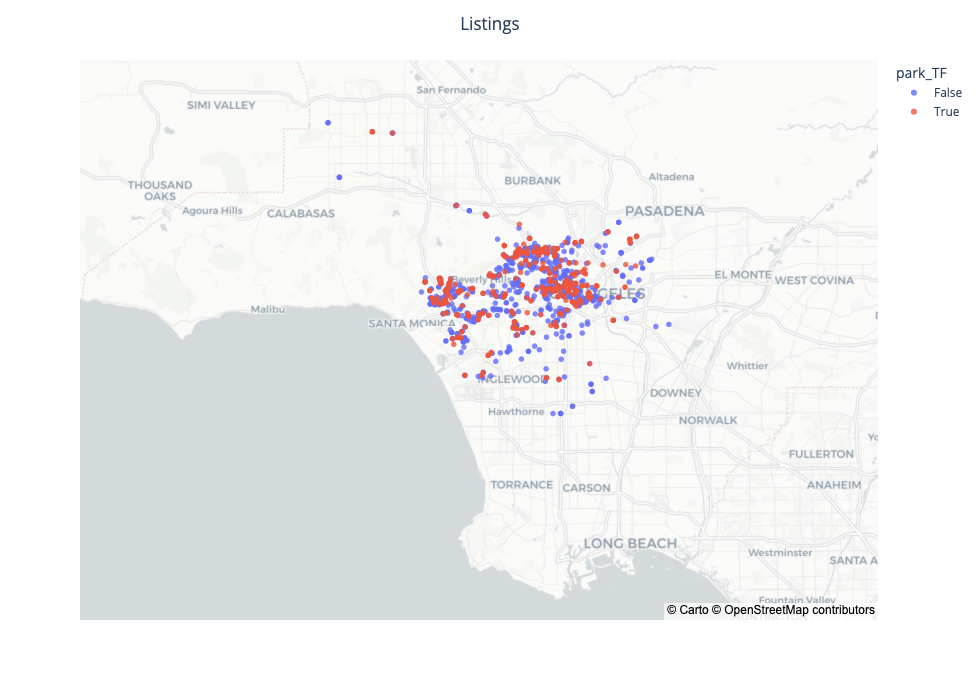

In [202]:
# import libraries
import plotly.express as px
import matplotlib.pyplot as plt


# create scatter map
fig = px.scatter_mapbox(test, lat=test.geometry.y, lon=test.geometry.x, color="park_TF",
                               mapbox_style="carto-positron",
                               #range_color=range_color,
                               zoom=9,
                               center = {"lat": 34, "lon": -118.4},
                               opacity=.8,

                               )

# options on the layout
fig.update_layout(
        width = 900,
        height = 700,
        title = "Listings",
        title_x = .5
    )
fig.show()

In [203]:
listingsDf_trim.to_pickle("./listings_sorted.pkl")